# Phase Classification
## Pre-defined features

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import *
from tensorflow.keras.layers import *

In [4]:
def evaluate_model(build_model, x_train, y_train, x_test, y_test):
    epoch_convergence = []
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    model_history_of_last_run = []

    # build and train model
    for i in range(5):
        model = build_model()

        model_history = model.fit(x_train, y_train,
                                  batch_size=128,
                                  epochs=20,
                                  verbose=0,
                                  validation_data=(x_test, y_test))

        # Report model summary once
        if i == 0:
            model.summary()

        epoch_number_after_train_accuracy_convergence = find_stable_epoch(model_history, 'accuracy')
        epoch_number_after_test_accuracy_convergence = find_stable_epoch(model_history, 'val_accuracy')

        epoch_number_after_model_convergence = max(epoch_number_after_train_accuracy_convergence,
                                                   epoch_number_after_test_accuracy_convergence)

        # evaluate model
        score = model.evaluate(x_test, y_test, verbose=0)

        # Append data
        epoch_convergence.append(epoch_number_after_model_convergence)
        train_loss.append(model_history.history['loss'][-1])
        train_accuracy.append(model_history.history['accuracy'][-1])
        test_loss.append(score[0])
        test_accuracy.append(score[1])

        # Save a sample of the training history
        if i == 4:
            model_history_of_last_run = model_history

    average_epoch_after_convergence = np.average(epoch_convergence)
    average_loss_train = np.average(train_loss)
    average_accuracy_train = np.average(train_accuracy)
    average_loss_test = np.average(test_loss)
    average_accuracy_test = np.average(test_accuracy)

    return ({'Average epoch after convergence': average_epoch_after_convergence,
             'Average training loss': average_loss_train,
             'Average training accuracy': average_accuracy_train,
             'Average test loss': average_loss_test,
             'Average test accuracy': average_accuracy_test}, model_history_of_last_run)


def find_stable_epoch(model_history, identifier):
    identical_accuracy_count = 0
    last_accuracy_value = 0
    stable_epoch_number = 0
    for index, accuracy in enumerate(model_history.history[identifier]):
        if last_accuracy_value == accuracy:
            identical_accuracy_count += 1
        if identical_accuracy_count == 4:
            stable_epoch_number = index + 1
            break
        last_accuracy_value = accuracy

    if stable_epoch_number == 0:
        stable_epoch_number = -1

    return stable_epoch_number


def visualize_training(model_history, model_name):
    # visualize history for accuracy
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.ylabel('model accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.title('Accuracy of {model_name} w.r.t. training epochs'.format(model_name=model_name))
    plt.show()
    # visualize history for loss
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.ylabel('model loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.title('Loss of {model_name} w.r.t. training epochs'.format(model_name=model_name))
    plt.show()


def report_and_visualize_model_performance(build_model, x_train, y_train, x_test, y_test, model_name):
    performance_report, model_history_sample = evaluate_model(build_model, x_train, y_train, x_test, y_test)
    visualize_training(model_history_sample, model_name)
    print(json.dumps(performance_report, indent=2))

def magnetization(data):
    configuration = data
    m = np.sum(np.sum(configuration,axis=2),axis=1)
    return m

In [5]:
x_train = np.load("x_train.npy")
x_test = np.load("x_test.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

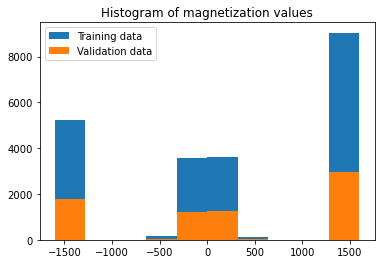

In [6]:
# Calculate magnetization for spin configurations
magnetization_train = magnetization(x_train)
magnetization_test = magnetization(x_test)

# Visualize dataset
plt.hist(magnetization_train, label="Training data")
plt.hist(magnetization_test, label="Validation data")
plt.legend()
plt.title("Histogram of magnetization values")
plt.show()

In [7]:
# Construct features based on magnetization

def get_new_features(data):
    new_dataset = []

    for magnetization in data:
        if magnetization > 1000:
            new_dataset.append([1,0,0])
        elif magnetization < -1000:
            new_dataset.append([0,0,1])
        else:
            new_dataset.append([0,1,0])

    return np.array(new_dataset)

x_new_train = get_new_features(magnetization_train)
x_new_test = get_new_features(magnetization_test)

In [8]:
np.save("x_new_train.npy", x_new_train)
np.save("x_new_test.npy", x_new_test)

Model: "Dense_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  256       
_________________________________________________________________
dense_1 (Dense)              multiple                  65        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
{
  "Average epoch after convergence": 5.8,
  "Average training loss": 0.0001168220944236964,
  "Average training accuracy": 1.0,
  "Average test loss": 0.00010870864061871544,
  "Average test accuracy": 1.0
}


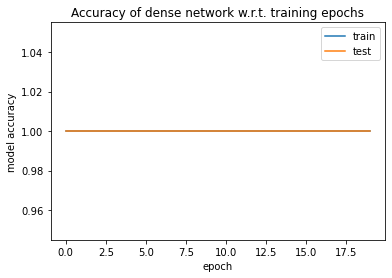

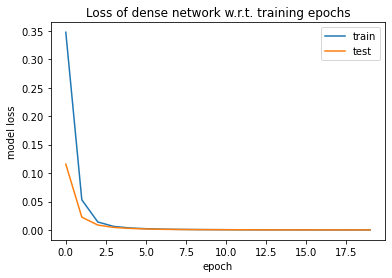

In [6]:
# First attempt using the best model of third bullet point

def build_model_1():
    model = Sequential(name='Dense_network')
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

    return model

report_and_visualize_model_performance(build_model_1, x_new_train, y_train, x_new_test, y_test, 'dense network')

Model: "Dense_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             multiple                  512       
_________________________________________________________________
dense_11 (Dense)             multiple                  129       
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________
{
  "Average epoch after convergence": 6.0,
  "Average training loss": 5.651263491017744e-05,
  "Average training accuracy": 1.0,
  "Average test loss": 5.2819125266978516e-05,
  "Average test accuracy": 1.0
}


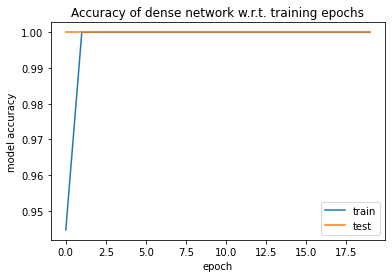

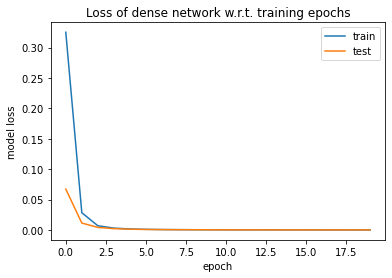

In [7]:
# Second attempt using more hidden units
def build_model_2():
    model = Sequential(name='Dense_network')
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

    return model

report_and_visualize_model_performance(build_model_2, x_new_train, y_train, x_new_test, y_test, 'dense network')

Model: "Dense_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             multiple                  32        
_________________________________________________________________
dense_21 (Dense)             multiple                  9         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
{
  "Average epoch after convergence": 6.4,
  "Average training loss": 0.0014813504414632917,
  "Average training accuracy": 1.0,
  "Average test loss": 0.0013774942606687545,
  "Average test accuracy": 1.0
}


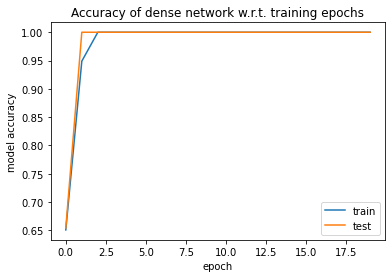

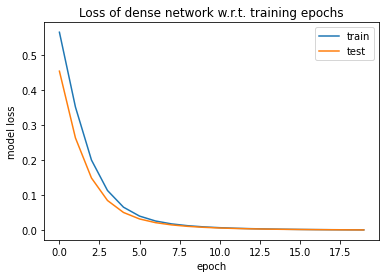

In [8]:
# Third attempt using less hidden units
def build_model_3():
    model = Sequential(name='Dense_network')
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

    return model

report_and_visualize_model_performance(build_model_3, x_new_train, y_train, x_new_test, y_test, 'dense network')

Model: "Dense_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             multiple                  4         
_________________________________________________________________
dense_31 (Dense)             multiple                  2         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
{
  "Average epoch after convergence": 7.2,
  "Average training loss": 0.1570933748036623,
  "Average training accuracy": 0.9311010003089905,
  "Average test loss": 0.15593032725155354,
  "Average test accuracy": 0.9308349370956421
}


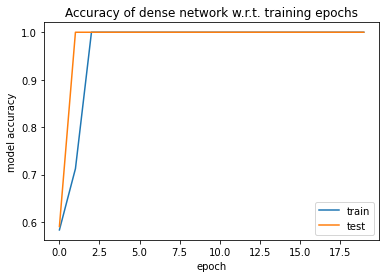

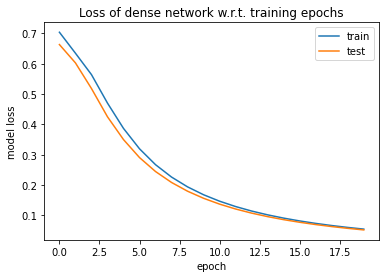

In [9]:
# Fourth attempt using even less hidden units
def build_model_4():
    model = Sequential(name='Dense_network')
    model.add(Dense(1, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

    return model

report_and_visualize_model_performance(build_model_4, x_new_train, y_train, x_new_test, y_test, 'dense network')

Model: "Dense_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             multiple                  4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________
{
  "Average epoch after convergence": 5.8,
  "Average training loss": 0.06749261319637298,
  "Average training accuracy": 1.0,
  "Average test loss": 0.06461241990327835,
  "Average test accuracy": 1.0
}


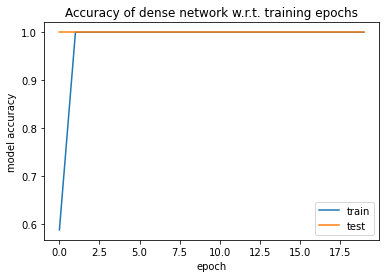

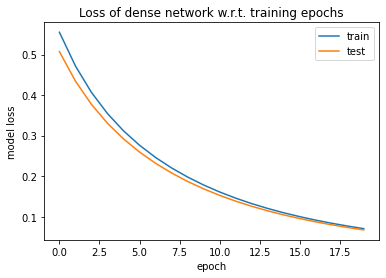

In [10]:
# Fifth attempt without using a hidden layer
def build_model_5():
    model = Sequential(name='Dense_network')
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

    return model

report_and_visualize_model_performance(build_model_5, x_new_train, y_train, x_new_test, y_test, 'dense network')

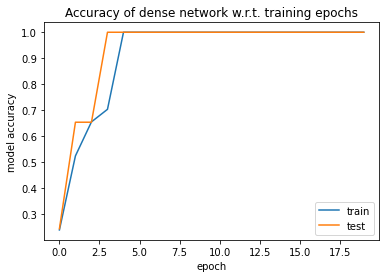

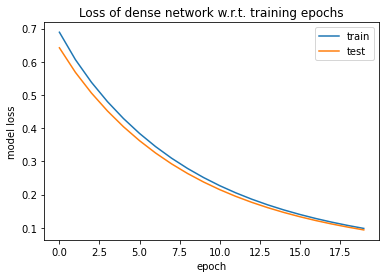

In [11]:
model_with_predefined_features = build_model_5()
history  = model_with_predefined_features.fit(x_new_train, y_train, batch_size=128, epochs=20, verbose=0, validation_data=(x_new_test, y_test))
visualize_training(history, 'dense network')
model_with_predefined_features.save("model_predefined_features.h5")
model_with_predefined_features.save_weights("final_weights_model_predefined_features.h5")

